## Addining Color To Images Through Feature Loss Application
In this notebook, we will train a model to add color to images using the same method applied in [Part II - Super Resolution Using Feature Losses](https://github.com/danieldiamond/dl-projects/blob/master/super-resolution/part-ii-super-res-using-feature-loss.ipynb).<br><br>
Here, instead of training a model to enhance the resolution, we will train a model to add color to greyscale images.

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [7]:
path = Path('/home/danieldiamond1/.fastai/data/imagenet_sample/')
path_hr = path/'color'
path_lr = path/'new_bw'

In [8]:
il = ImageItemList.from_folder(path_hr)

In [11]:
# Previously we created low-res images to train on. This time we will create 3 channel greyscale images.
def blackandwhite(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn).convert('L')
    img = PIL.Image.fromarray(np.stack((np.array(img.convert('L')),)*3, axis=-1))
    img.save(dest)

In [12]:
parallel(blackandwhite, il.items)

In [13]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [14]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [15]:
data = get_data(bs,size)

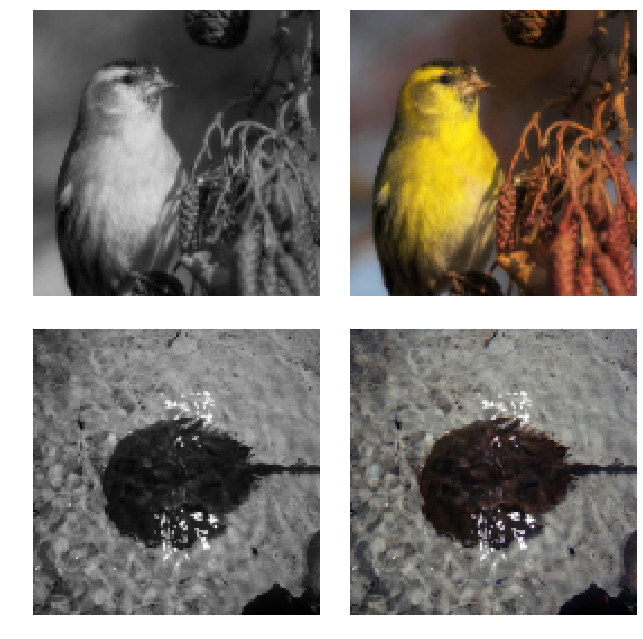

In [16]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [17]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [18]:
'''
A gram matrix is used to capture the similarity between two objects. 
More specifically, the matrix of each object (e.g. an image) is converted into a vector
and all these new vectors are grouped together to create a matrix M. Therefore:
G = M.T * M
where each element G(i,j) represents the similarity measure between image i and j
'''

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [19]:
gram_matrix(t)

tensor([[[0.0769, 0.0590, 0.0295],
         [0.0590, 0.0473, 0.0236],
         [0.0295, 0.0236, 0.0171]],

        [[0.0769, 0.0590, 0.0295],
         [0.0590, 0.0473, 0.0236],
         [0.0295, 0.0236, 0.0171]]])

In [20]:
# Loss Function Typically MSE or L1
base_loss = F.l1_loss

In [21]:
# model.features is the convolutional part of the model 
# (remember we don't need the output/head)
vgg_m = vgg16_bn(True).features.cuda().eval()
# we don't want to update the model, we want the values for the loss
requires_grad(vgg_m, False)

Below, we iterate over all the layers in the convulational part of the model and find all the max pooling layers. If you scroll up to the first graph, you will note that the feature maps are obtained from layers that are located right before a grid size change, thus we take `i-1` layer. Not suprisingly, as shown below, these are all ReLU layers with which we will get our values from.

In [22]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [23]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        # m_feat is the model with which we want to calculate the features
        self.m_feat = m_feat
        # grab all specific layers
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        # use hooks to grab the values of the intermediate values
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        """
        We pass through the target (y/out_feat) and the input (output of a generator)
        and get a copy of the stored activations at these layers.
        """
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        # input is the output of the generator model
        # target is the original image (y)
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        
        # Calculate the L1 ;oss of the pixels
        self.feat_losses = [base_loss(input,target)]
        
        # Calculate the L1 loss of all the features
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [24]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [25]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


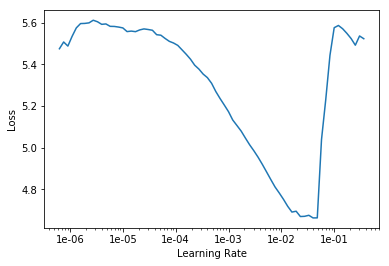

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
lr = 1e-3

In [28]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycles=20):
    learn.fit_one_cycle(cycles, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,4.689219,4.439808,0.586338,0.287025,0.384827,0.223018,0.805567,1.425198,0.727835
2,4.268975,3.908671,0.429533,0.254974,0.336347,0.206861,0.711360,1.259937,0.709659
3,3.955423,3.593591,0.408735,0.227239,0.301858,0.195209,0.623226,1.148197,0.689127
4,3.720497,3.460269,0.413109,0.217782,0.287588,0.185580,0.595476,1.097912,0.662822
5,3.553065,3.339020,0.389944,0.207633,0.275465,0.183292,0.566300,1.049784,0.666602
6,3.422974,3.313203,0.395786,0.205630,0.271412,0.179225,0.566848,1.041139,0.653164
7,3.307003,3.251951,0.390055,0.198080,0.267134,0.175134,0.551320,1.029655,0.640574
8,3.218808,3.132859,0.377837,0.190198,0.255244,0.169148,0.537652,0.981115,0.621665
9,3.161701,3.129378,0.358717,0.184579,0.253817,0.170604,0.536671,0.993177,0.631814
10,3.096003,3.111535,0.343933,0.185961,0.254690,0.172467,0.525969,0.996072,0.632442


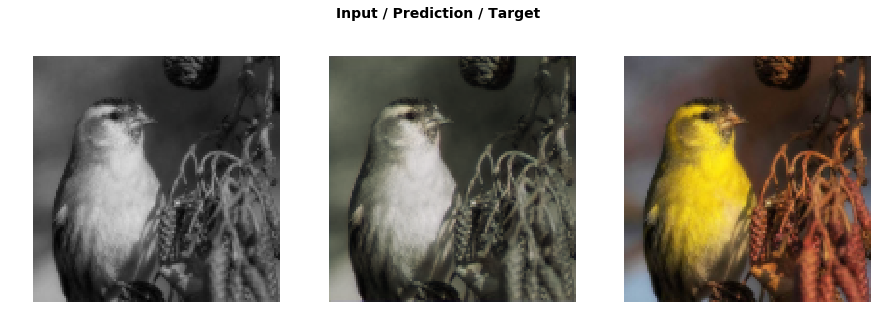

In [29]:
do_fit('1a', slice(lr*5))

In [30]:
learn.unfreeze()

In [90]:
do_fit('1b', slice(1e-5,1e-3),cycles=10)

In [32]:
# Now lets increase the image size (and halve the batch size)
data = get_data(bs//2,size*2)
learn.data = data
learn.freeze()

In [91]:
do_fit('2a',cycles=5)

In [34]:
learn.unfreeze()

In [92]:
do_fit('2b', slice(1e-5,1e-3),cycles=5)

In [ ]:
# do_fit('2c', slice(1e-6,1e-4),cycles=5)

In [36]:
# Now lets increase the image size (and halve the batch size)
data = get_data(bs//8,size*4)
learn.data = data
learn.freeze()

In [93]:
do_fit('3a',cycles=10)

In [38]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,1.152022,1.164945,0.255284,0.155370,0.172883,0.057463,0.231707,0.226655,0.065583
2,1.164515,1.163262,0.254542,0.155019,0.172797,0.057527,0.231874,0.225705,0.065798
3,1.152392,1.165062,0.255244,0.155283,0.173074,0.057636,0.231688,0.226417,0.065721
4,1.145864,1.166259,0.255796,0.155998,0.173534,0.057521,0.231266,0.226373,0.065772
5,1.141800,1.164036,0.255085,0.155195,0.172842,0.057455,0.231784,0.226028,0.065648
6,1.152149,1.161829,0.253585,0.156035,0.173630,0.057617,0.229755,0.225338,0.065870
7,1.142537,1.166632,0.256434,0.155988,0.173458,0.057434,0.231415,0.226326,0.065576
8,1.138723,1.161079,0.254326,0.154975,0.172694,0.057352,0.231300,0.224915,0.065518
9,1.151548,1.162851,0.255148,0.154906,0.172854,0.057663,0.231771,0.224776,0.065734
10,1.133714,1.160202,0.253724,0.156207,0.173448,0.057356,0.229377,0.224639,0.065453


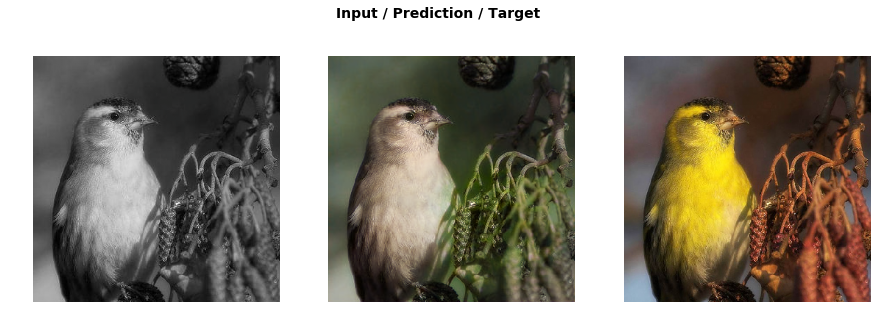

In [42]:
do_fit('3b', slice(1e-6,1e-4),cycles=20)

## Test

In [51]:
def compare_images(i=100):
    real_img = open_image(Path('/home/danieldiamond1/.fastai/data/imagenet_sample/bw/').ls()[i])
    _,img_hr,b = learn.predict(real_img)
    show_image(real_img, figsize=(18,15));
    Image(img_hr).show(figsize=(18,15));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


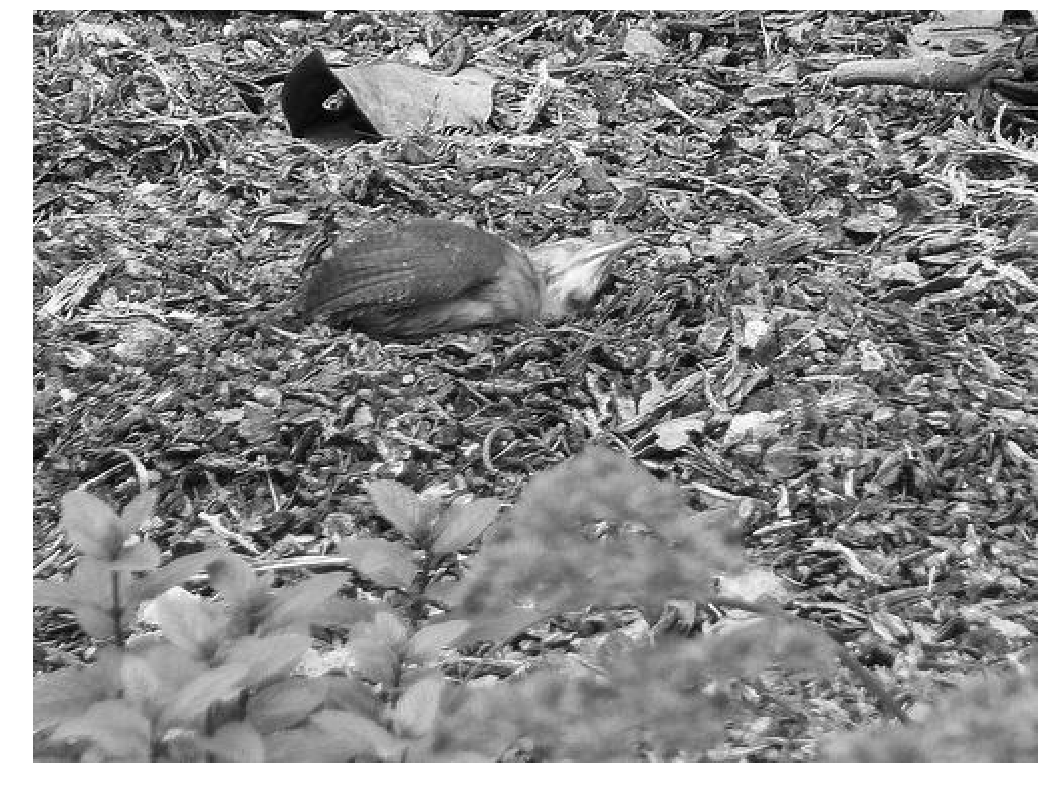

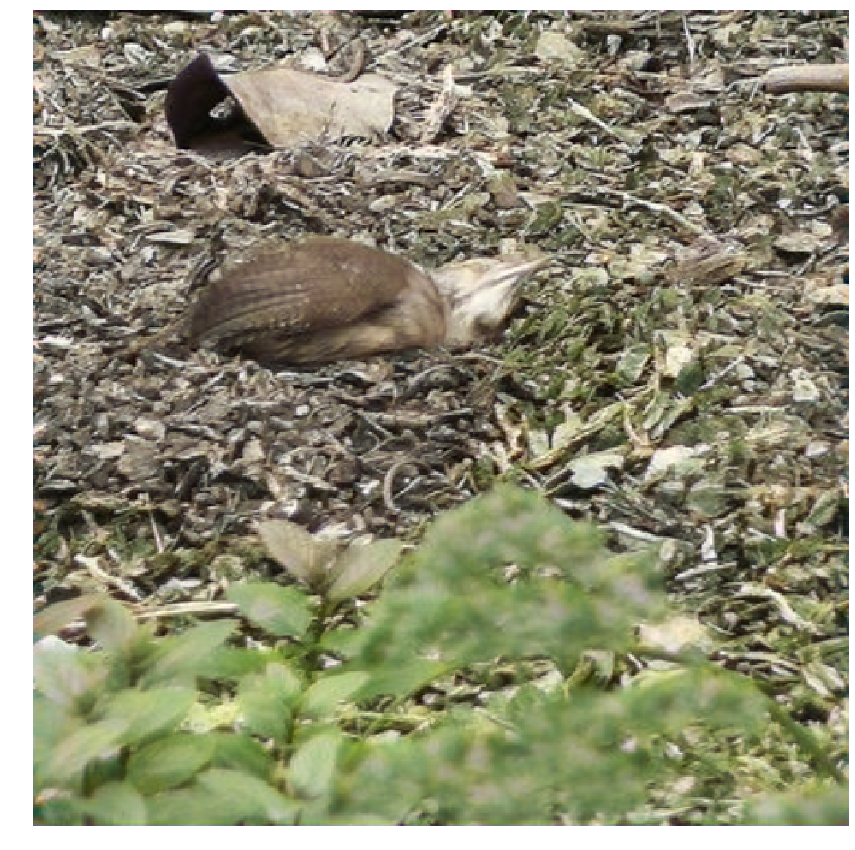

In [112]:
compare_images(i=np.random.randint(0,len(path_lr.ls())))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


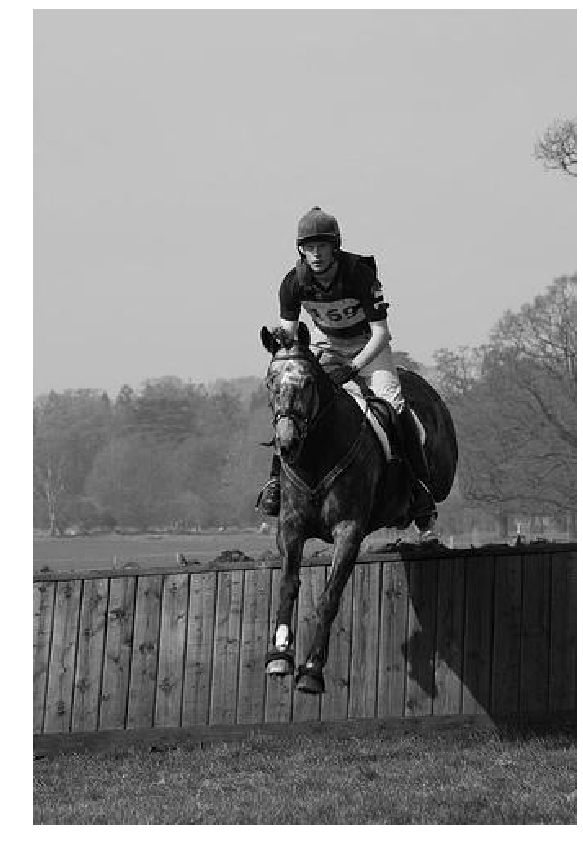

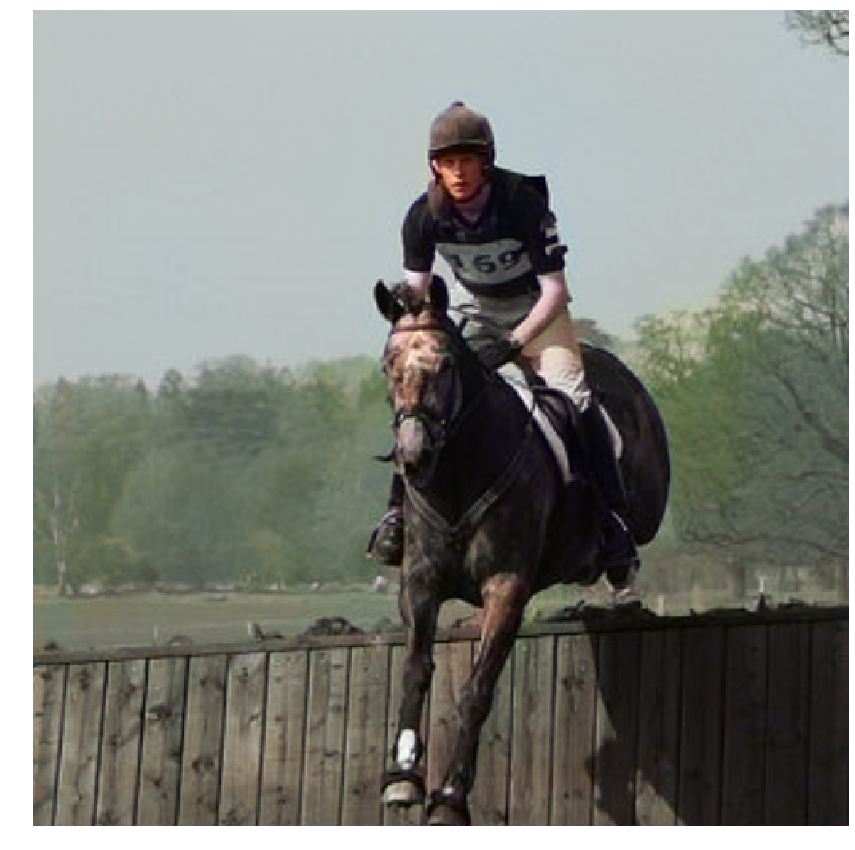

In [53]:
compare_images(i=10)

## Discussion & Improvements
Whilst these results are quite impressive, further improvements could be made by training on a significantly larger dataset consisting of a diverse range of photographs. This would allow the U-Net model to gain a deeper understanding of color-shape associations.